In [8]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [9]:
# Load the datasets
train_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Train.csv')
test_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv')
validation_df = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_Validation.csv')

In [10]:
# Function to preprocess datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [11]:
def add_cyclical_features(df, col_name, max_val):
    if col_name in df.columns:
        df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
        df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df


for df in [train_df, validation_df, test_df]:
    df = add_cyclical_features(df, 'Hour', 23)
    df = add_cyclical_features(df, 'Day', 31) 
    df = add_cyclical_features(df, 'Month', 12)


In [12]:
def add_lagged_features(df, feature_cols, n_lags=3):
    for feature in feature_cols:
        for lag in range(1, n_lags + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df.dropna().reset_index(drop=True)

# Preprocess all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

# Specifying the features to lag
features_to_lag = ['Average_Temp', 'MW']

# Applying the function to your datasets
train_df = add_lagged_features(train_df, features_to_lag, n_lags=3)
validation_df = add_lagged_features(validation_df, features_to_lag, n_lags=3)
test_df = add_lagged_features(test_df, features_to_lag, n_lags=3)


In [13]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)

y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Creating polynomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Applying transformation to all datasets.
train_features = train_df.drop(columns=['MW'])
validation_features = validation_df.drop(columns=['MW'])
test_features = test_df.drop(columns=['MW'])

X_train_poly = poly.fit_transform(train_features)
X_validation_poly = poly.transform(validation_features)
X_test_poly = poly.transform(test_features)


feature_names = poly.get_feature_names_out(input_features=train_features.columns)


y_train = train_df['MW']
y_validation = validation_df['MW']
y_test = test_df['MW']


In [15]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # Calculate MAE and RMSE
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # Calculate Modified MAPE with capped at 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # Calculate sMAPE
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse


In [9]:
# Don't run this cell otherwise it will start training the model again
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from joblib import dump, load

# Pipeline for standardizing dataset
pipeline = make_pipeline(StandardScaler(), Ridge())


alpha_values = np.logspace(-1, 20, 10000)

# Setting up the GridSearchCV object with 5-fold cross-validation
parameters = {'ridge__alpha': alpha_values}
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_absolute_error', verbose=2)

# Fitting GridSearchCV on the training data with polynomial features
grid_search.fit(X_train_poly, y_train)

# Retrieve the best model from grid search
best_model_Ridge = grid_search.best_estimator_

print("Best model parameters:", grid_search.best_params_)
print("Best model score (negative MAE):", grid_search.best_score_)

# Save the model to a file
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V3.joblib'
dump(best_model_Ridge, model_filename)


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................ridge__alpha=0.10048476241819601; total time=   0.0s
[CV] END ...................ridge__alpha=0.10048476241819601; total time=   0.0s
[CV] END ...................ridge__alpha=0.10048476241819601; total time=   0.0s
[CV] END ...................ridge__alpha=0.10048476241819601; total time=   0.0s
[CV] END ...................ridge__alpha=0.10048476241819601; total time=   0.0s
[CV] END ...................ridge__alpha=0.10097187478241294; total time=   0.0s
[CV] END ...................ridge__alpha=0

['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V2.joblib']

In [16]:
from joblib import dump, load
# Predict on the validation set using the best model
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V3.joblib'
best_model_Ridge_loaded = load(model_filename)
predictions_validation = best_model_Ridge_loaded.predict(X_validation_poly)

metrics_validation = calculate_metrics(y_validation, predictions_validation)

print("Validation Metrics after tuning with Polynomial Features (MAE, MAPE, sMAPE, RMSE):", metrics_validation)

Validation Metrics after tuning with Polynomial Features (MAE, MAPE, sMAPE, RMSE): (9.766902688238698, 20.823582158905797, 19.646867331327474, 15.328372317239358)


In [17]:
# Evaluation with polynomial features
predictions_test = best_model_Ridge_loaded.predict(X_test_poly)
metrics_test = calculate_metrics(y_test, predictions_test)

print("Test Metrics with Ridge Regression and Polynomial Features (MAE, MAPE, sMAPE, RMSE):", metrics_test)


Test Metrics with Ridge Regression and Polynomial Features (MAE, MAPE, sMAPE, RMSE): (8.201393814874082, 15.029151136478486, 15.027891691878468, 11.788409827189408)


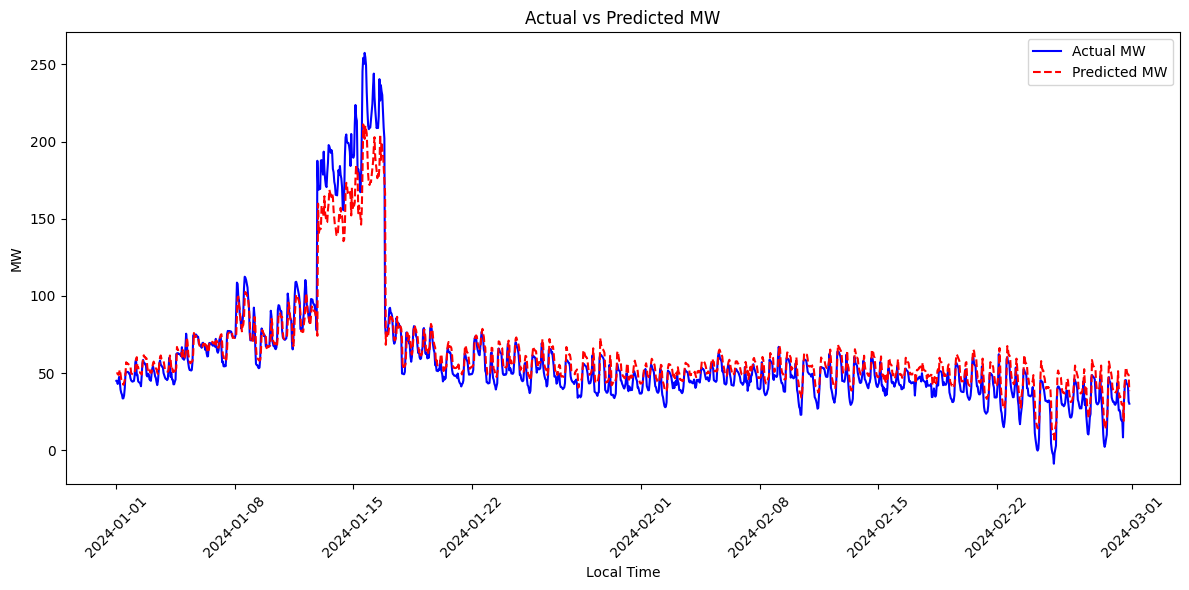

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the 'local_time' column from the test dataset again
test_df_for_plotting = pd.read_csv('/Users/alitahseen/Desktop/FYP-2024/Machine_learning/Datafiles/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

# Ensuring the length of test_local_time matches y_test_pred and y_test
if len(test_local_time) > len(predictions_test):
    test_local_time = test_local_time[:len(predictions_test)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue') 
plt.plot(test_local_time, predictions_test, label='Predicted MW', color='red', linestyle='--')
plt.title('Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Evaluate the best model on the training set
y_train_pred = best_model_Ridge_loaded.predict(X_train_poly)  # Predicting on the training features
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training Metrics: MAE={train_metrics[0]}, MAPE={train_metrics[1]}, sMAPE={train_metrics[2]}, RMSE={train_metrics[3]}")

# Comparing the metrics
print("Comparing Training, Validation, and Test Metrics:")
print("Training: ", train_metrics)
print("Validation: ", metrics_validation)
print("Test: ", metrics_test)


Training Metrics: MAE=7.230704024521266, MAPE=11.516594158957105, sMAPE=11.454688339958475, RMSE=17.740536669189737
Comparing Training, Validation, and Test Metrics:
Training:  (7.230704024521266, 11.516594158957105, 11.454688339958475, 17.740536669189737)
Validation:  (9.766902688238698, 20.823582158905797, 19.646867331327474, 15.328372317239358)
Test:  (8.201393814874082, 15.029151136478486, 15.027891691878468, 11.788409827189408)


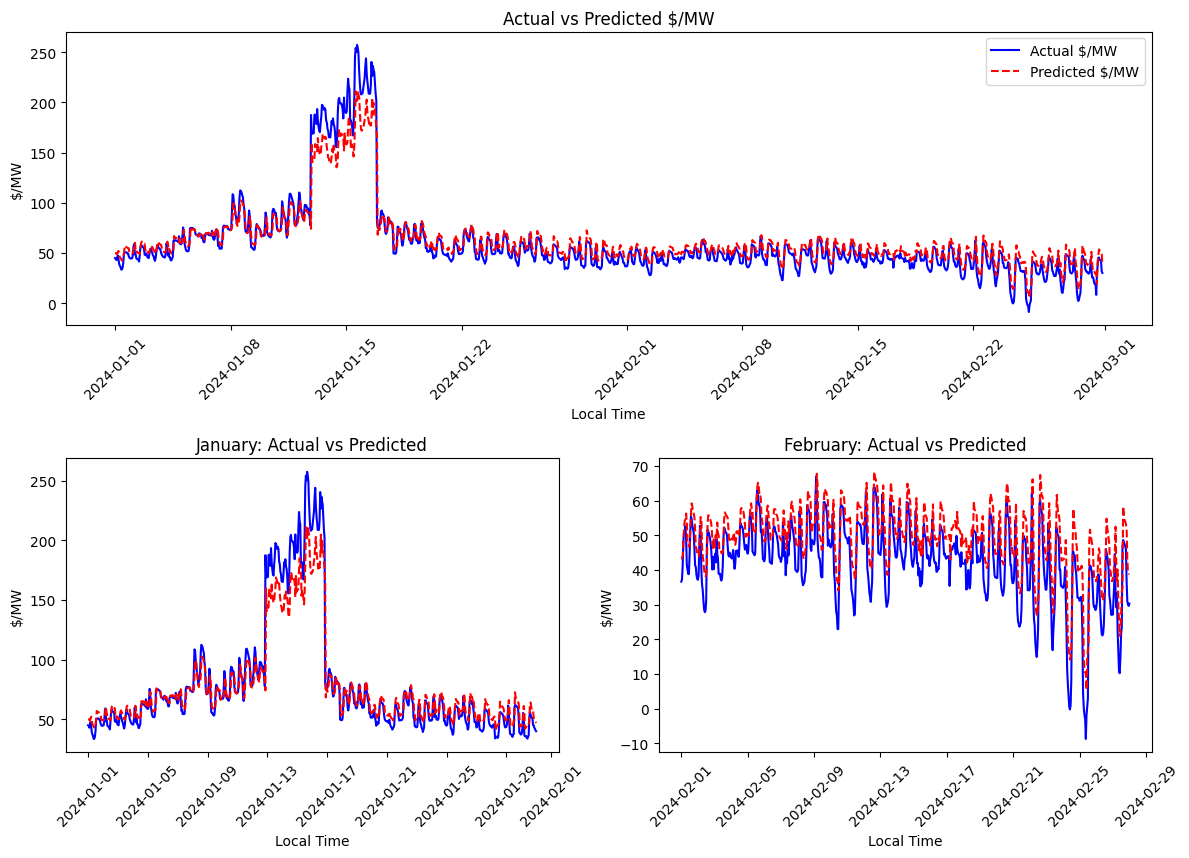

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = predictions_test[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = predictions_test[is_february]


plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)


ax0 = plt.subplot(gs[0, :]) 
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, predictions_test, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)


ax1 = plt.subplot(gs[1, 0])
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)


ax2 = plt.subplot(gs[1, 1])
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [24]:
print(metrics_test[1])

15.029151136478486


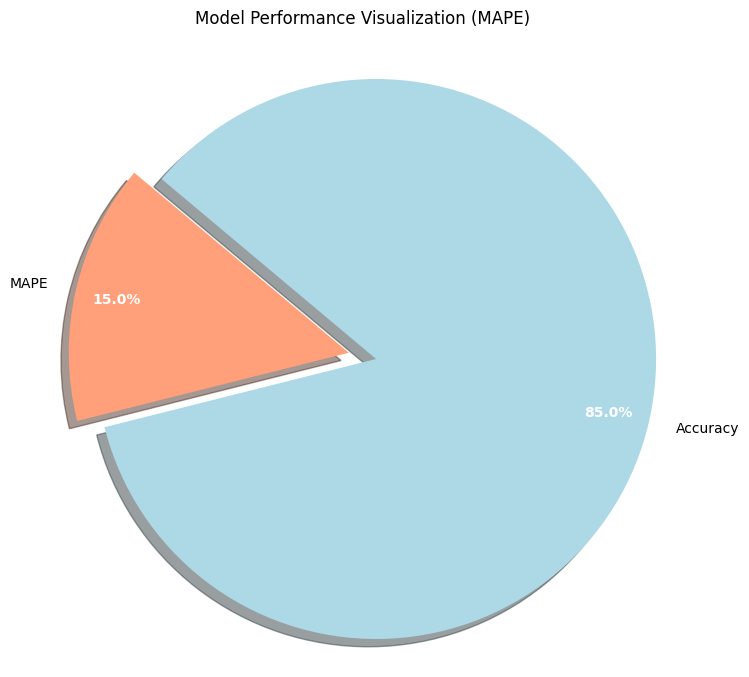

In [29]:
import matplotlib.pyplot as plt


remainder = 100 - metrics_test[1]  # Using MAPE to calculate the remainder

# Data to plot
labels = ['MAPE', 'Accuracy']
sizes = [metrics_test[1], remainder]
colors = ['#FFA07A', '#ADD8E6'] 
explode = (0.1, 0)  

# Plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, pctdistance=0.85)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Enhance the look & feel
plt.setp(texts, color='black')
plt.setp(autotexts, size=10, weight="bold", color="white")

plt.title('Model Performance Visualization (MAPE)', pad=20)
plt.show()


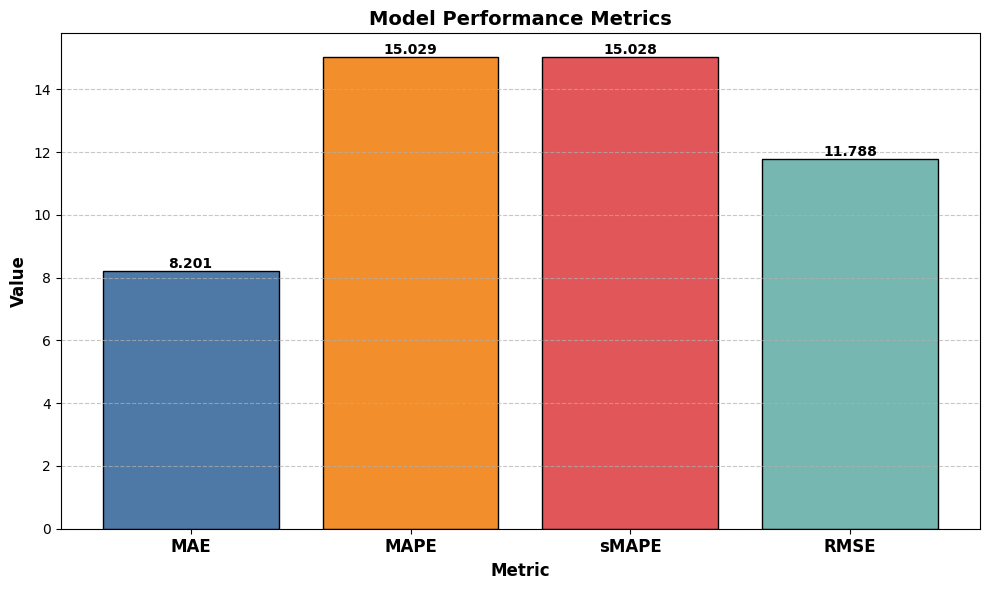

In [31]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, metrics_test, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
from joblib import dump

# Adjusting the range for alpha_values
alpha_values = np.logspace(-4, 6, 100)  # More focused range based on common practical ranges

# Pipeline for preprocessing and modeling
pipeline = make_pipeline(StandardScaler(), Ridge())

# Setting up the GridSearchCV object with TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
parameters = {'ridge__alpha': alpha_values}
grid_search = GridSearchCV(pipeline, parameters, cv=tscv, scoring='neg_mean_absolute_error', verbose=2)

# Fitting GridSearchCV on the polynomial-features-transformed training data
grid_search.fit(X_train_poly, y_train)

# Retrieving the best model from the grid search
best_model_Ridge = grid_search.best_estimator_

print("Best model parameters:", grid_search.best_params_)
print("Best model score (negative MAE):", grid_search.best_score_)

# Save the model to a file
# Save the model to a file
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V4.joblib'
dump(best_model_Ridge, model_filename)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ................................ridge__alpha=0.0001; total time=   0.2s
[CV] END ................................ridge__alpha=0.0001; total time=   0.0s
[CV] END ................................ridge__alpha=0.0001; total time=   0.0s
[CV] END ................................ridge__alpha=0.0001; total time=   0.0s
[CV] END ................................ridge__alpha=0.0001; total time=   0.1s
[CV] END .................ridge__alpha=0.0001261856883066021; total time=   0.0s
[CV] END .................ridge__alpha=0.0001261856883066021; total time=   0.0s
[CV] END .................ridge__alpha=0.0001261856883066021; total time=   0.0s
[CV] END .................ridge__alpha=0.0001261856883066021; total time=   0.1s
[CV] END .................ridge__alpha=0.0001261856883066021; total time=   0.1s
[CV] END ................ridge__alpha=0.00015922827933410923; total time=   0.0s
[CV] END ................ridge__alpha=0.000159

['/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V4.joblib']

In [19]:
from joblib import dump, load
# Predict on the validation set using the best model
model_filename = '/Users/alitahseen/Desktop/FYP-2024/Machine_learning/notebooks/Trained_Models/best_ridge_model_V4.joblib'
best_model_Ridge_loaded = load(model_filename)

In [20]:
# Evaluate the best model on the training set
y_train_pred = best_model_Ridge_loaded.predict(X_train_poly)  # Predicting on the training features
train_metrics = calculate_metrics(y_train, y_train_pred)
print(f"Training Metrics: MAE={train_metrics[0]}, MAPE={train_metrics[1]}, sMAPE={train_metrics[2]}, RMSE={train_metrics[3]}")

predictions_validation = best_model_Ridge_loaded.predict(X_validation_poly)

metrics_validation = calculate_metrics(y_validation, predictions_validation)

print("Validation Metrics after tuning with Polynomial Features (MAE, MAPE, sMAPE, RMSE):", metrics_validation)

# Evaluation with polynomial features
predictions_test = best_model_Ridge_loaded.predict(X_test_poly)
metrics_test = calculate_metrics(y_test, predictions_test)

print("Test Metrics with Ridge Regression and Polynomial Features (MAE, MAPE, sMAPE, RMSE):", metrics_test)



Training Metrics: MAE=7.065794213257423, MAPE=11.099607740900232, sMAPE=11.054929444607884, RMSE=17.50714073432321
Validation Metrics after tuning with Polynomial Features (MAE, MAPE, sMAPE, RMSE): (9.031442116218653, 19.217536552538878, 18.200534939083415, 14.624919915766856)
Test Metrics with Ridge Regression and Polynomial Features (MAE, MAPE, sMAPE, RMSE): (7.63709140802884, 13.942661012811449, 14.068965323714737, 11.09226809759169)


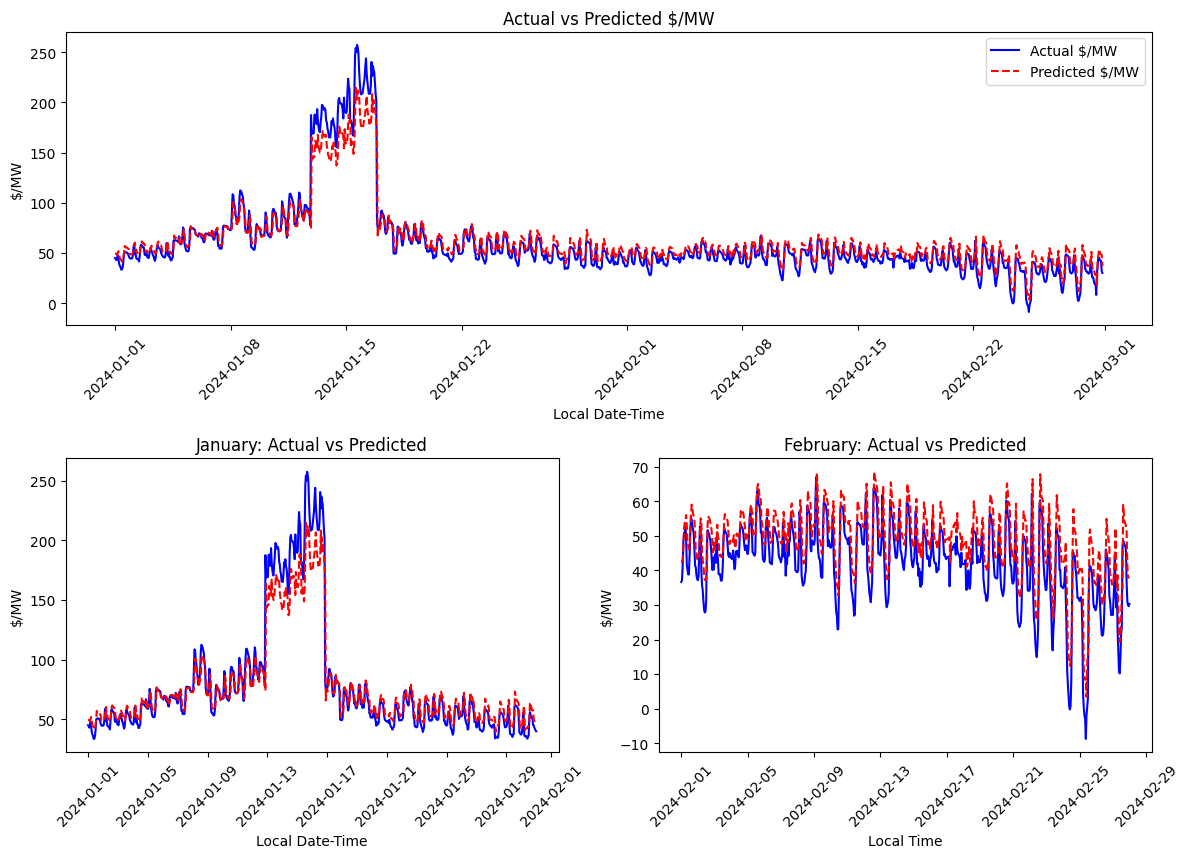

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-01"
january_end = "2024-01-31"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = predictions_test[is_january]

# Filter for February
february_start = "2024-02-01"
february_end = "2024-02-28"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = predictions_test[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(3, 2)  # Define a grid of 3 rows and 2 columns

# Main plot spanning the first row
ax0 = plt.subplot(gs[0, :])  # This subplot takes up the first row
ax0.plot(test_local_time, y_test, label='Actual $/MW', color='blue')
ax0.plot(test_local_time, predictions_test, label='Predicted $/MW', color='red', linestyle='--')
ax0.set_title('Actual vs Predicted $/MW')
ax0.set_xlabel('Local Date-Time')
ax0.set_ylabel('$/MW')
ax0.legend()
ax0.tick_params(axis='x', rotation=45)

# January subplot in the second row, first column
ax1 = plt.subplot(gs[1, 0])  # Bottom left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January: Actual vs Predicted')
ax1.set_xlabel('Local Date-Time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)

# February subplot in the second row, second column
ax2 = plt.subplot(gs[1, 1])  # Bottom right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February: Actual vs Predicted')
ax2.set_xlabel('Local Time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()


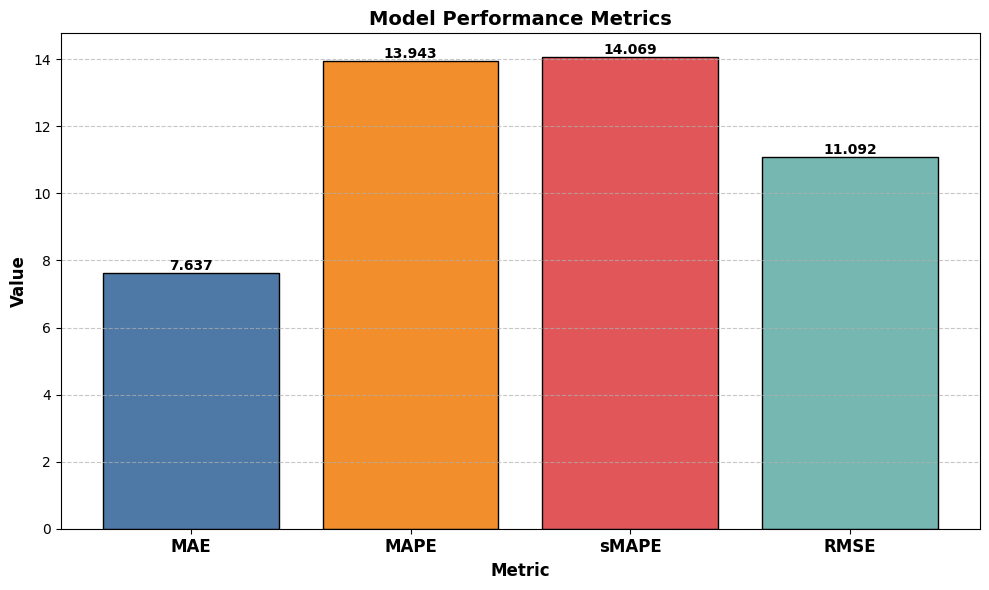

In [26]:
import matplotlib.pyplot as plt
import numpy as np


# Metric names
metrics_names = ['MAE', 'MAPE', 'sMAPE', 'RMSE']

# Creating an array with the positions of the bars along the x-axis
x_pos = np.arange(len(metrics_names))

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(x_pos, metrics_test, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'], edgecolor='black')

# Adding the metric names as labels on the x-axis
plt.xticks(x_pos, metrics_names, fontsize=12, fontweight='bold')

# Adding a title and labels for the axes
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.xlabel('Metric', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=12, fontweight='bold')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Adding gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


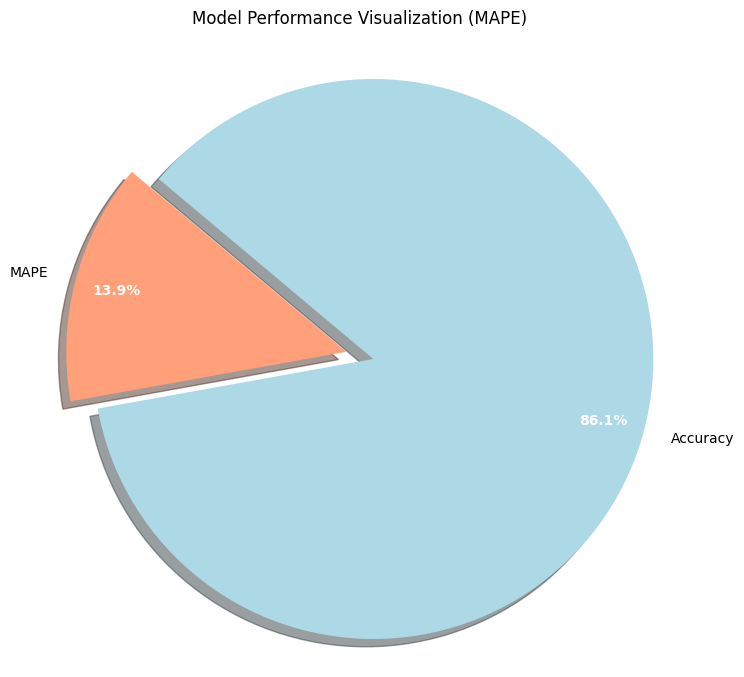

In [27]:
import matplotlib.pyplot as plt


remainder = 100 - metrics_test[1]  # Using MAPE to calculate the remainder

# Data to plot
labels = ['MAPE', 'Accuracy']
sizes = [metrics_test[1], remainder]
colors = ['#FFA07A', '#ADD8E6'] 
explode = (0.1, 0)  

# Plot
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, pctdistance=0.85)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  

# Enhance the look & feel
plt.setp(texts, color='black')
plt.setp(autotexts, size=10, weight="bold", color="white")

plt.title('Model Performance Visualization (MAPE)', pad=20)
plt.show()


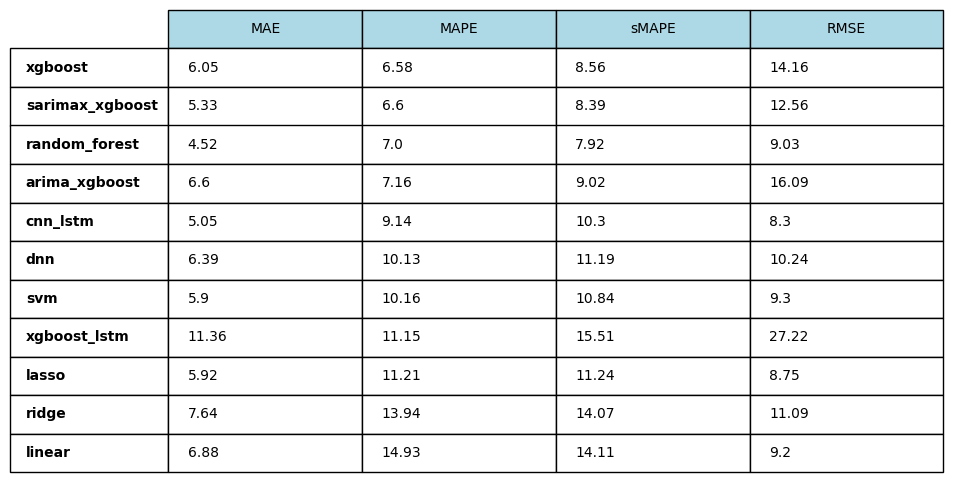

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided data
data = {
    'xgboost': {'MAE': 6.05, 'MAPE': 6.58, 'sMAPE': 8.56, 'RMSE': 14.16},
    'sarimax_xgboost': {'MAE': 5.33, 'MAPE': 6.60, 'sMAPE': 8.39, 'RMSE': 12.56},
    'random_forest': {'MAE': 4.52, 'MAPE': 7.00, 'sMAPE': 7.92, 'RMSE': 9.03},
    'arima_xgboost': {'MAE': 6.60, 'MAPE': 7.16, 'sMAPE': 9.02, 'RMSE': 16.09},
    'cnn_lstm': {'MAE': 5.05, 'MAPE': 9.14, 'sMAPE': 10.30, 'RMSE': 8.30},
    'dnn': {'MAE': 6.39, 'MAPE': 10.13, 'sMAPE': 11.19, 'RMSE': 10.24},
    'svm': {'MAE': 5.90, 'MAPE': 10.16, 'sMAPE': 10.84, 'RMSE': 9.30},
    'xgboost_lstm': {'MAE': 11.36, 'MAPE': 11.15, 'sMAPE': 15.51, 'RMSE': 27.22},
    'lasso': {'MAE': 5.92, 'MAPE': 11.21, 'sMAPE': 11.24, 'RMSE': 8.75},
    'ridge': {'MAE': 7.64, 'MAPE': 13.94, 'sMAPE': 14.07, 'RMSE': 11.09},
    'linear': {'MAE': 6.88, 'MAPE': 14.93, 'sMAPE': 14.11, 'RMSE': 9.20},
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table
the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells
        if j == -1:  # Model name column
            cell.set_text_props(fontweight='bold')  # Bold font for model names

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


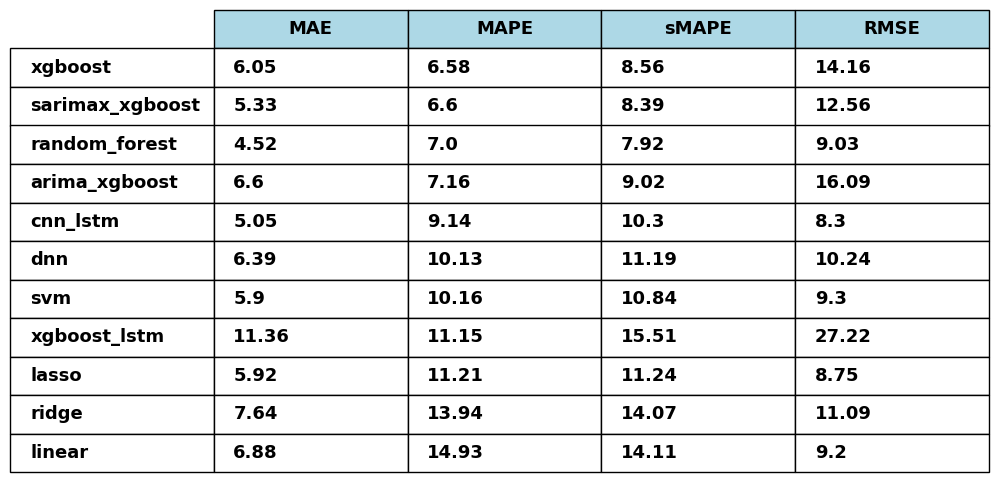

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided data
data = {
    'xgboost': {'MAE': 6.05, 'MAPE': 6.58, 'sMAPE': 8.56, 'RMSE': 14.16},
    'sarimax_xgboost': {'MAE': 5.33, 'MAPE': 6.60, 'sMAPE': 8.39, 'RMSE': 12.56},
    'random_forest': {'MAE': 4.52, 'MAPE': 7.00, 'sMAPE': 7.92, 'RMSE': 9.03},
    'arima_xgboost': {'MAE': 6.60, 'MAPE': 7.16, 'sMAPE': 9.02, 'RMSE': 16.09},
    'cnn_lstm': {'MAE': 5.05, 'MAPE': 9.14, 'sMAPE': 10.30, 'RMSE': 8.30},
    'dnn': {'MAE': 6.39, 'MAPE': 10.13, 'sMAPE': 11.19, 'RMSE': 10.24},
    'svm': {'MAE': 5.90, 'MAPE': 10.16, 'sMAPE': 10.84, 'RMSE': 9.30},
    'xgboost_lstm': {'MAE': 11.36, 'MAPE': 11.15, 'sMAPE': 15.51, 'RMSE': 27.22},
    'lasso': {'MAE': 5.92, 'MAPE': 11.21, 'sMAPE': 11.24, 'RMSE': 8.75},
    'ridge': {'MAE': 7.64, 'MAPE': 13.94, 'sMAPE': 14.07, 'RMSE': 11.09},
    'linear': {'MAE': 6.88, 'MAPE': 14.93, 'sMAPE': 14.11, 'RMSE': 9.20},
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'lightblue'  # Header background color
header_text_color = 'black'  # Header text color
cell_color = 'white'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table
the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table with bolder text
the_table.auto_set_font_size(False)
the_table.set_fontsize(13)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color, fontweight='bold')
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=13, fontweight='bold')  # Apply bold font to all cells

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()


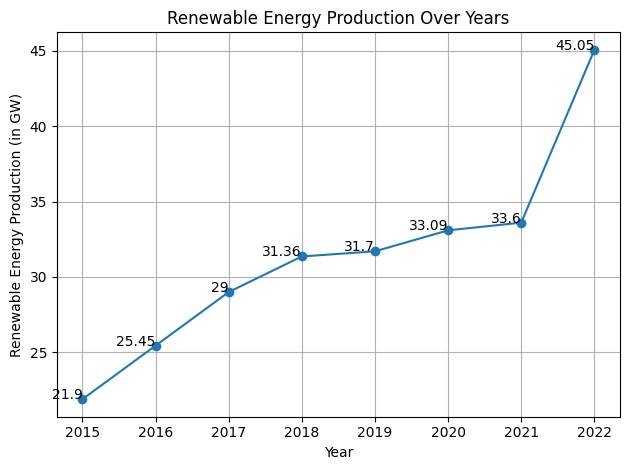

In [1]:
import matplotlib.pyplot as plt

# Data
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
renewable_energy_production = [21.90, 25.45, 29, 31.36, 31.70, 33.09, 33.6, 45.05]

# Plotting the line graph
plt.plot(years, renewable_energy_production, marker='o', linestyle='-')

# Adding labels to data points
for i in range(len(years)):
    plt.text(years[i], renewable_energy_production[i], str(renewable_energy_production[i]), ha='right')

# Adding title and labels
plt.title('Renewable Energy Production Over Years')
plt.xlabel('Year')
plt.ylabel('Renewable Energy Production (in GW)')

# Display the graph
plt.grid(True)
plt.xticks(years)
plt.tight_layout()
plt.show()


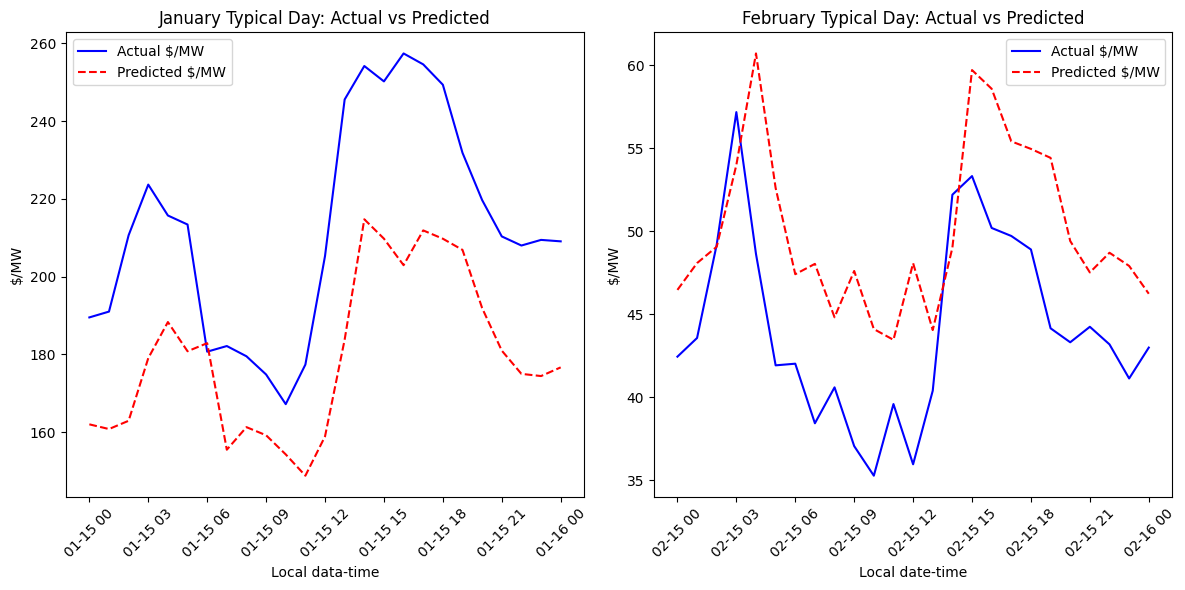

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Convert 'test_local_time' to datetime if it's not already
test_local_time = pd.to_datetime(test_local_time)

# Filter for January
january_start = "2024-01-15"
january_end = "2024-01-16"
is_january = (test_local_time >= january_start) & (test_local_time <= january_end)
january_times = test_local_time[is_january]
january_actual = y_test[is_january]
january_predictions = predictions_test[is_january]

# Filter for February
february_start = "2024-02-15"
february_end = "2024-02-16"
is_february = (test_local_time >= february_start) & (test_local_time <= february_end)
february_times = test_local_time[is_february]
february_actual = y_test[is_february]
february_predictions = predictions_test[is_february]

# Set up the plot layout
plt.figure(figsize=(12, 6))  # Adjusted for a wider aspect to accommodate two columns
gs = gridspec.GridSpec(1, 2)  # Adjusted to define a grid of 1 row and 2 columns

# January subplot in the first row, first column
ax1 = plt.subplot(gs[0, 0])  # Top left
ax1.plot(january_times, january_actual, label='Actual $/MW', color='blue')
ax1.plot(january_times, january_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax1.set_title('January Typical Day: Actual vs Predicted')
ax1.set_xlabel('Local data-time')
ax1.set_ylabel('$/MW')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# February subplot in the first row, second column
ax2 = plt.subplot(gs[0, 1])  # Top right
ax2.plot(february_times, february_actual, label='Actual $/MW', color='blue')
ax2.plot(february_times, february_predictions, label='Predicted $/MW', color='red', linestyle='--')
ax2.set_title('February Typical Day: Actual vs Predicted')
ax2.set_xlabel('Local date-time')
ax2.set_ylabel('$/MW')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()  # Adjust layout to make room for all elements
plt.show()


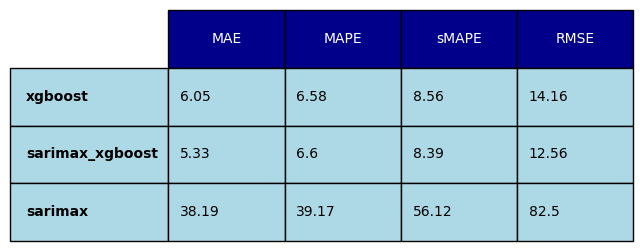

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided data
data = {
    'xgboost': {'MAE': 6.05, 'MAPE': 6.58, 'sMAPE': 8.56, 'RMSE': 14.16},
    'sarimax_xgboost': {'MAE': 5.33, 'MAPE': 6.60, 'sMAPE': 8.39, 'RMSE': 12.56},
    'sarimax': {'MAE':38.19, 'MAPE':39.17, 'sMAPE': 56.12, 'RMSE': 82.5},
}

# Convert the dictionary into a DataFrame and sort it by MAPE
df = pd.DataFrame(data).T.sort_values(by='MAPE')

# Adjust figure size to better fit the table
fig, ax = plt.subplots(figsize=(6, 3))  # Increased figure size for better cell spacing
ax.axis('off')  # Hide the axes

# Table properties
table_props = dict(cellLoc='left', loc='center', edges='closed')  # Align text to left
header_color = 'darkblue'  # Header background color
header_text_color = 'white'  # Header text color
cell_color = 'lightblue'  # Cell background color
cell_edge_color = 'black'  # Cell edge color

# Creating the table
the_table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     rowLabels=df.index,
                     bbox=[0, 0, 1, 1],  # Use bbox to make the table fill the figure
                     **table_props)

# Styling the table
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)  # Adjust font size for better readability

# Apply cell properties and set header color
for (i, j), cell in the_table.get_celld().items():
    if i == 0:  # Header row
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text_color)
        cell.set_edgecolor(cell_edge_color)
    else:
        cell.set_facecolor(cell_color)
        cell.set_edgecolor(cell_edge_color)
        cell.set_text_props(fontsize=10)  # Apply font size to other cells
        if j == -1:  # Model name column
            cell.set_text_props(fontweight='bold')  # Bold font for model names

fig.patch.set_facecolor('white')  # Set the figure background to white
plt.show()
